In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# pylab结合了pyplot和numpy，对交互式使用来说比较方便，既可以画图又可以进行简单的计算
# 但对于一个项目来说，建议分别倒入使用
from itertools import cycle
import seaborn as sns
from IPython.display import HTML
from tqdm import tqdm

In [2]:
pd.set_option('max_columns',50) # 用于设置dataframe的输出显示，此处表示设置最多显示50列
plt.style.use('bmh') # 设置内置图表样式：bmh,fivethirtyeight,ggplot,grayscale,dack_background
# 详见https://blog.csdn.net/qq_42505705/article/details/84962815

In [3]:
plt.rcParams['figure.figsize'] = (12, 8) # 设置图像大小
plt.rcParams['axes.titlesize'] = 16 # 设置标题字体大小

In [4]:
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color'] # 储存内置颜色。color_pal: color palette
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color']) # 循环使用内置颜色

In [5]:
sns.set_style('whitegrid') # 设置主题：darkgrid 黑色网格（默认）,whitegrid 白色网格,dark 黑色背景,white 白色背景,ticks 四周都有刻度线的白背景
sns.set_context('poster') # 四种预设，按相对尺寸的顺序(线条越来越粗)，分别是paper，notebook, talk, and poster。默认使用notebook。

In [6]:
# calendar.csv-包含有关产品销售日期的信息。
# sales_train_validation.csv-包含每个商店中的每类商品的历史日销售数据[d_1-d_1913]
# sample_submission.csv-提交的正确格式。有关详细信息，请参阅“评估”选项卡。
# sell_prices.csv-包含每个商店每天销售的商品的价格信息。

In [7]:
cal = pd.read_csv('F:\electric books\kaggle competition\competition resources\m5-forecasting-accuracy\calendar.csv')
stv = pd.read_csv('F:\electric books\kaggle competition\competition resources\m5-forecasting-accuracy\sales_train_validation.csv')
ss = pd.read_csv('F:\electric books\kaggle competition\competition resources\m5-forecasting-accuracy\sample_submission.csv')
sellp = pd.read_csv('F:\electric books\kaggle competition\competition resources\m5-forecasting-accuracy\sell_prices.csv')

In [8]:
sellp.tail() # 显示sellp最后5条数据

,store_id,item_id,wm_yr_wk,sell_price
6841116,WI_3,FOODS_3_827,11617,1.0
6841117,WI_3,FOODS_3_827,11618,1.0
6841118,WI_3,FOODS_3_827,11619,1.0
6841119,WI_3,FOODS_3_827,11620,1.0
6841120,WI_3,FOODS_3_827,11621,1.0


In [9]:
cal.shape

(1969, 14)

In [10]:
cal.head()
# d: data organized in this column, corresponding to train 
# event_name_1,event_type_1,event_name_2,event_type_2: event name if special events happen, else NaN
# snap_Ca, snap_tx, snap_wi: snap provides low income family and individuals with extra benefits to purchase food, usually 10 days per month

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [11]:
cal.tail()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [12]:
cal.dtypes

date            object
wm_yr_wk         int64
weekday         object
wday             int64
month            int64
year             int64
d               object
event_name_1    object
event_type_1    object
event_name_2    object
event_type_2    object
snap_CA          int64
snap_TX          int64
snap_WI          int64
dtype: object

In [13]:
cal_na = (cal.isnull().sum() / len(cal)) # 计算每个特征的missing ratio
cal_na = cal_na.drop(cal_na[cal_na == 0].index).sort_values(ascending=False) # 剔除无空值列的统计（只关心有空值的列），然后按空值比例降序排序
missing_data = pd.DataFrame({'Missing Ratio':cal_na}) # 转换成dataframe，看起来更立体美观
missing_data

,Missing Ratio
event_type_2,0.997461
event_name_2,0.997461
event_type_1,0.917725
event_name_1,0.917725


In [14]:
stv.shape

(30490, 1919)

In [15]:
stv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [16]:
stv.dtypes

id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
state_id    object
d_1          int64
d_2          int64
d_3          int64
d_4          int64
d_5          int64
d_6          int64
d_7          int64
d_8          int64
d_9          int64
d_10         int64
d_11         int64
d_12         int64
d_13         int64
d_14         int64
d_15         int64
d_16         int64
d_17         int64
d_18         int64
d_19         int64
d_20         int64
d_21         int64
d_22         int64
d_23         int64
d_24         int64
             ...  
d_1884       int64
d_1885       int64
d_1886       int64
d_1887       int64
d_1888       int64
d_1889       int64
d_1890       int64
d_1891       int64
d_1892       int64
d_1893       int64
d_1894       int64
d_1895       int64
d_1896       int64
d_1897       int64
d_1898       int64
d_1899       int64
d_1900       int64
d_1901       int64
d_1902       int64
d_1903       int64
d_1904       int64
d_1905      

In [17]:
stv_na = stv.isnull().sum() / len(stv)
stv_na = stv_na.drop(stv_na[stv_na == 0].index).sort_values(ascending=False)
# drop()默认删除行
missing_data = pd.DataFrame({'Missing Ratio':stv_na})
missing_data

,Missing Ratio


In [18]:
sellp.head()
# 与cal共用wm_yr_wk

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [19]:
sellp.dtypes

store_id       object
item_id        object
wm_yr_wk        int64
sell_price    float64
dtype: object

In [20]:
sellp_na = sellp.isnull().sum() / len(sellp)
sellp_na = sellp_na.drop(sellp_na[sellp_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio':sellp_na})
missing_data

,Missing Ratio


In [21]:
ss.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
ss.dtypes

id     object
F1      int64
F2      int64
F3      int64
F4      int64
F5      int64
F6      int64
F7      int64
F8      int64
F9      int64
F10     int64
F11     int64
F12     int64
F13     int64
F14     int64
F15     int64
F16     int64
F17     int64
F18     int64
F19     int64
F20     int64
F21     int64
F22     int64
F23     int64
F24     int64
F25     int64
F26     int64
F27     int64
F28     int64
dtype: object

In [23]:
itemInDept_meanSales = stv.groupby(['dept_id']).mean()
# 显示每天各部门中所有商品的平均销售额，比如在dept_id='FOODS_1'的部门中，第1天部门所有商品的平均销售额为1.084722
itemInDept_meanSales

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
dept_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOODS_1,1.084722,1.025926,0.767130,0.698148,0.559722,0.878241,0.881019,1.034722,0.891204,0.734259,0.826389,0.804167,0.948148,1.087500,1.364815,1.707407,1.015278,0.718519,0.748611,0.695370,0.863889,1.106944,1.001852,0.825926,0.685185,...,1.154167,1.575463,1.604630,1.535185,1.199074,1.234259,1.229630,1.246759,1.495833,1.839815,1.601389,1.299074,1.298611,1.199537,1.195833,1.477778,1.631019,1.417593,1.139352,1.177778,1.230093,1.221759,1.467130,1.718519,1.474537
FOODS_2,1.028643,1.057538,0.797487,0.906030,0.720854,1.099246,0.841457,1.101508,1.073618,0.925628,0.817839,0.928643,0.902513,0.940452,1.186432,1.228392,0.759045,0.979648,0.808794,0.701005,0.761307,0.960050,0.968090,0.800000,0.652764,...,1.054020,1.453266,1.811055,2.066332,1.550754,1.636683,1.568593,1.380653,1.518090,2.147990,2.030402,1.719849,1.623618,1.287437,1.386432,1.422362,1.455276,1.655276,1.318342,1.241709,1.189447,1.117085,1.249749,1.387940,1.626382
FOODS_3,2.034143,1.984569,1.499757,1.672418,1.278858,1.922357,1.851519,2.567679,2.267801,1.656258,1.448724,1.485055,1.421628,1.573026,2.128433,2.196719,1.312394,1.454921,1.277643,1.214824,1.421385,1.789307,1.702430,1.385784,1.210814,...,1.875942,2.362090,2.868773,3.170474,2.219077,2.194775,2.228311,2.122357,2.451519,3.136209,3.026245,2.362090,2.206197,1.965128,2.108748,2.409356,2.757230,3.019077,2.240948,2.121750,1.973390,1.972296,2.255286,2.757108,2.794168
HOBBIES_1,0.867788,0.762500,0.600240,0.608413,0.412019,0.753125,0.686298,0.920913,0.658894,0.604327,0.579808,0.566106,0.606731,0.648558,0.857452,0.774279,0.506250,0.574279,0.488221,0.460337,0.512260,0.957933,0.675240,0.608654,0.563462,...,0.746154,1.059375,1.071635,1.080288,0.789663,0.766587,0.728606,0.725962,0.875240,1.042548,0.969471,0.816106,0.725000,0.764904,0.809135,0.809375,1.014423,1.039663,0.730288,0.822115,0.755048,0.724519,0.884135,1.056971,1.015865
HOBBIES_2,0.103356,0.124161,0.124161,0.092617,0.067114,0.058389,0.059732,0.104027,0.106040,0.067785,0.090604,0.068456,0.118121,0.083221,0.088591,0.131544,0.085235,0.110738,0.093289,0.089933,0.102685,0.105369,0.113423,0.136242,0.077181,...,0.212752,0.257047,0.271812,0.274497,0.252349,0.193289,0.233557,0.283893,0.285235,0.269799,0.330201,0.215436,0.246980,0.251678,0.281879,0.281208,0.277852,0.332215,0.191275,0.246309,0.222148,0.227517,0.273154,0.261745,0.306711
HOUSEHOLD_1,0.771617,0.725188,0.531391,0.513534,0.338722,0.500752,0.594173,0.814662,0.656767,0.537030,0.461278,0.454511,0.471241,0.593609,0.765226,0.828383,0.474624,0.557143,0.529511,0.543985,0.656015,0.892857,0.858271,0.645301,0.531391,...,1.366353,1.861842,2.051692,2.087594,1.465226,1.381203,1.306015,1.344173,1.445301,1.965789,1.914850,1.441353,1.224060,1.143985,1.225376,1.386278,1.739286,1.827068,1.273684,1.313158,1.201692,1.236842,1.459023,1.794173,1.841165
HOUSEHOLD_2,0.307573,0.344854,0.213592,0.220000,0.180000,0.239612,0.274757,0.361359,0.287573,0.232816,0.214951,0.219029,0.234757,0.277087,0.364272,0.368932,0.200194,0.218835,0.214563,0.210680,0.262718,0.360971,0.332233,0.276699,0.227573,...,0.361942,0.429903,0.506796,0.540388,0.376117,0.313592,0.304660,0.362524,0.391456,0.545437,0.523883,0.379029,0.339612,0.322718,0.343301,0.377864,0.479223,0.505437,0.351262,0.359029,0.358447,0.346214,0.381748,0.524854,0.517087


In [24]:
itemInDept_meanSales_mean = stv.groupby(['dept_id']).mean().mean()
# 显示每天各部门中所有商品的平均销售额的平均值。此处没有用到。
itemInDept_meanSales_mean

d_1       0.885406
d_2       0.860677
d_3       0.647680
d_4       0.673023
d_5       0.508184
d_6       0.778817
d_7       0.741279
d_8       0.986410
d_9       0.848842
d_10      0.679729
d_11      0.634228
d_12      0.646567
d_13      0.671877
d_14      0.743350
d_15      0.965031
d_16      1.033665
d_17      0.621860
d_18      0.659155
d_19      0.594376
d_20      0.559448
d_21      0.654323
d_22      0.881919
d_23      0.807363
d_24      0.668372
d_25      0.564053
d_26      0.579931
d_27      0.563456
d_28      0.623808
d_29      0.840138
d_30      0.774929
            ...   
d_1884    1.523363
d_1885    1.271128
d_1886    0.992243
d_1887    0.938153
d_1888    0.901201
d_1889    0.967333
d_1890    1.285569
d_1891    1.455199
d_1892    1.536394
d_1893    1.121751
d_1894    1.102913
d_1895    1.085625
d_1896    1.066617
d_1897    1.208954
d_1898    1.563941
d_1899    1.485206
d_1900    1.176134
d_1901    1.094868
d_1902    0.990770
d_1903    1.050101
d_1904    1.166317
d_1905    1.

In [25]:
dept_totalSales = stv.groupby(['dept_id']).sum().T.reset_index(drop=True)
# 显示每天各部门中所有商品的总销售额
# 每日销售额按部门求和 -> 转置 -> 还原默认索引并删除原索引
# 转置是为了在使用disp_boxplot时方便计算各部门销售额的平均值（mean）和中位数（median）
dept_totalSales

dept_id,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2
0,2343,4094,16741,3610,154,4105,1584
1,2216,4209,16333,3172,185,3858,1776
2,1657,3174,12343,2497,185,2827,1100
3,1508,3606,13764,2531,138,2732,1133
4,1209,2869,10525,1714,100,1802,927
5,1897,4375,15821,3133,87,2664,1234
6,1903,3349,15238,2855,89,3161,1415
7,2235,4384,21132,3831,155,4334,1861
8,1925,4273,18664,2741,158,3494,1481
9,1586,3684,13631,2514,101,2857,1199


In [26]:
def disp_boxplot(data, title, xlabel, ylabel):
    sns.set_style('whitegrid')
    sns.set_context('poster')
    palette = sns.color_palette('hls', 8) # 调色盘，调用系统风格进行数据可视化。palette的色彩比color_pal更明亮。
    
    ax = sns.boxplot(data = data, palette = palette) # 绘制箱图
    ax.set(title = title, xlabel = xlabel, ylabel = ylabel) # 添加标题、横纵坐标标签
    
    try:
        # 添加基准线
        ax.axhline(y = data.mean().mean(), color = 'b', label = 'Mean of all datapoints', linestyle = '--', linewidth = 1.5)
        ax.axhline(y = data.median().median(), color = 'g', label = 'Median of all datapoints', linestyle = '--', linewidth = 1.5)
        # 第一个mean()表示对每个分组内数据求平均，第二个mean()表示对所有的分组平均值求平均。median()同理。
    except:
        pass
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45) # 将标签文字旋转45度，斜着显示文字，避免过于拥挤
    # xticklabels：x轴的刻度标签
    
    plt.legend() # 添加图例
    plt.show() # 显示图像

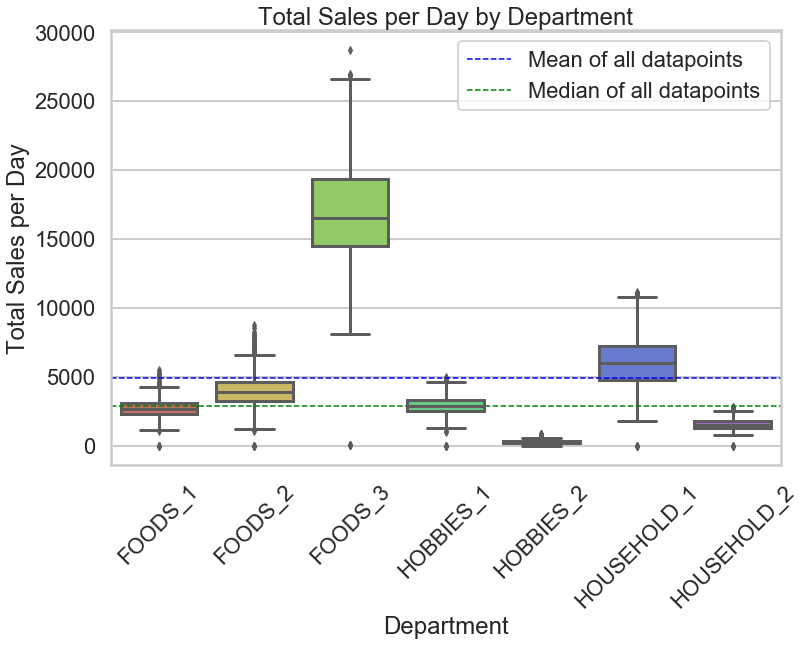

In [27]:
disp_boxplot(data = dept_totalSales, title = 'Total Sales per Day by Department',
             xlabel = 'Department', ylabel = 'Total Sales per Day')

1.部门FOOD_3的每日总销售额最高，并且显著高于其他部门以及平均值和中位数。

2.部门HOBBIES_2的每日总销售额最低，并且显著低于其他部门以及平均值和中位数。

3.不同部门的销售额差别很大，可能对之后的预测产生影响。

store_id     CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3
dept_id                                                                
FOODS_1       216   216   216   216   216   216   216   216   216   216
FOODS_2       398   398   398   398   398   398   398   398   398   398
FOODS_3       823   823   823   823   823   823   823   823   823   823
HOBBIES_1     416   416   416   416   416   416   416   416   416   416
HOBBIES_2     149   149   149   149   149   149   149   149   149   149
HOUSEHOLD_1   532   532   532   532   532   532   532   532   532   532
HOUSEHOLD_2   515   515   515   515   515   515   515   515   515   515


[Text(0.5,1,'Number of Items in Each Department per Store')]

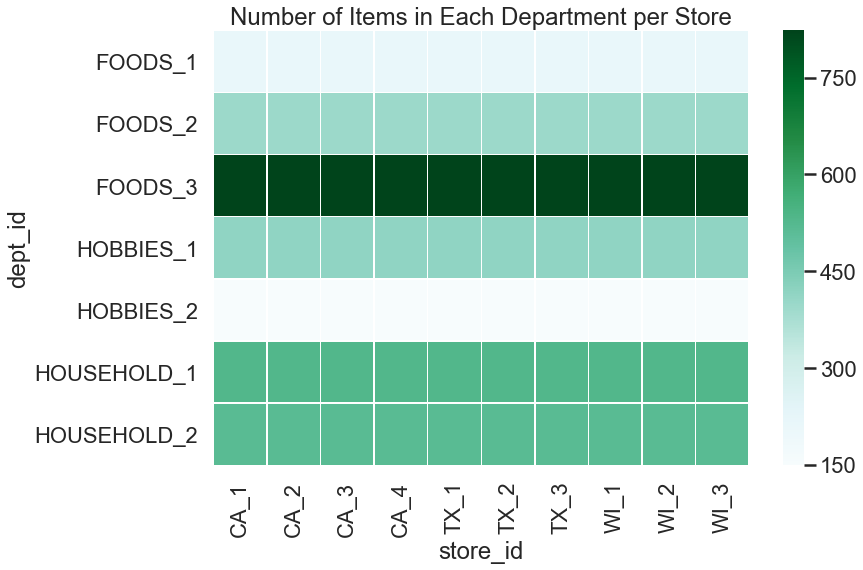

In [28]:
dept_store_cross = pd.crosstab(stv['dept_id'], stv['store_id'])
print(dept_store_cross)
ax = sns.heatmap(dept_store_cross, linewidths = 0.4, cmap = 'BuGn') # linewidths的作用是显示出heatmap中的每个cell，注意末尾要+s
ax.set(title = 'Number of Items in Each Department per Store')

各个门店的商品种类齐全。

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


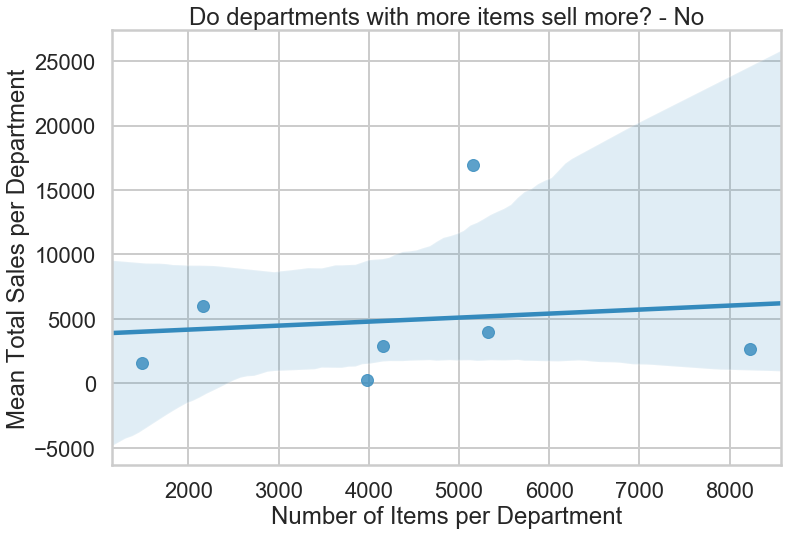

In [29]:
n_items_dept = stv['dept_id'].value_counts() # 各部门的商品个数
dept_totalSales_mean = dept_totalSales.mean() # 各部门总销售额的日平均值

ax = sns.regplot(n_items_dept, dept_totalSales_mean) # 绘制线图
ax.set(title = 'Do departments with more items sell more? - No',
       xlabel = 'Number of Items per Department', ylabel = 'Mean Total Sales per Department')
plt.show()

部门的品类数量与销售额无明显相关关系。

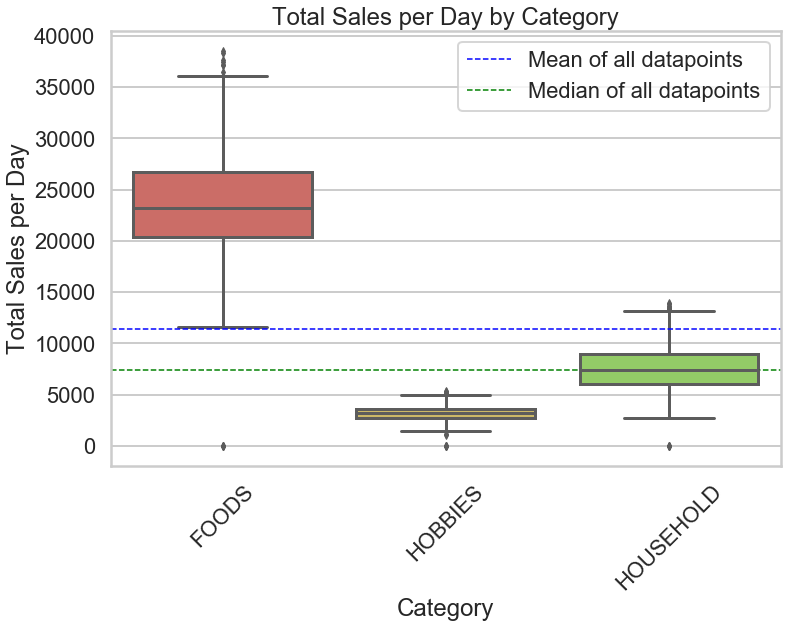

In [30]:
cat_totalSales = stv.groupby(['cat_id']).sum().T.reset_index(drop = True)
disp_boxplot(data = cat_totalSales, title = 'Total Sales per Day by Category',
             xlabel = 'Category', ylabel = 'Total Sales per Day')

1.大类（category）FOODS的每日总销售额最高，并且显著高于其他大类以及平均值和中位数。

2.大类HOBBIES的每日总销售额最低，并且显著低于其他部门以及平均值和中位数。

3.不同大类的销售额差别很大，可能对之后的预测产生影响。

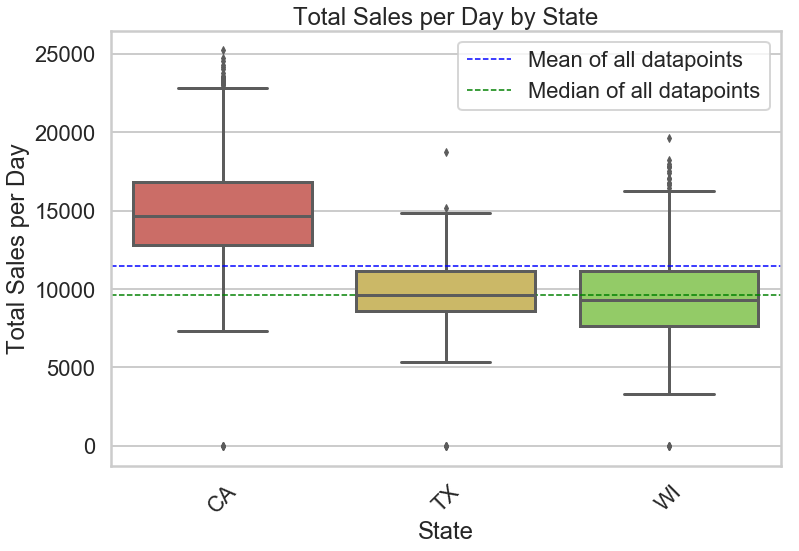

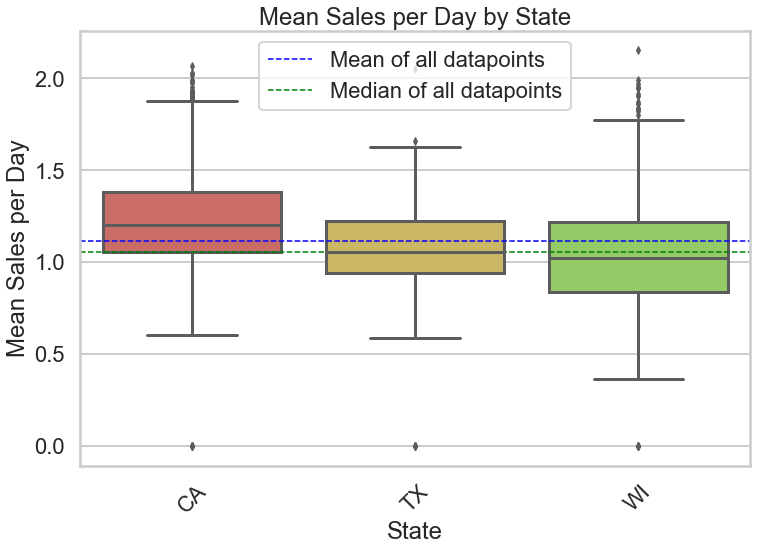

In [31]:
state_totalSales = stv.groupby(['state_id']).sum().T.reset_index(drop = True)
state_meanSales = stv.groupby(['state_id']).mean().T.reset_index(drop = True)

disp_boxplot(data = state_totalSales, title = 'Total Sales per Day by State',
             xlabel = 'State', ylabel = 'Total Sales per Day')
disp_boxplot(data = state_meanSales, title = 'Mean Sales per Day by State',
             xlabel = 'State', ylabel = 'Mean Sales per Day')

1.州CA的每日总销售额最高，且远高于其他州以及平均值和中位数。

2.但各州中平均每个门店的每日销售额差别不大，表明CA较高的总销售额只是因为CA的门店个数较多。

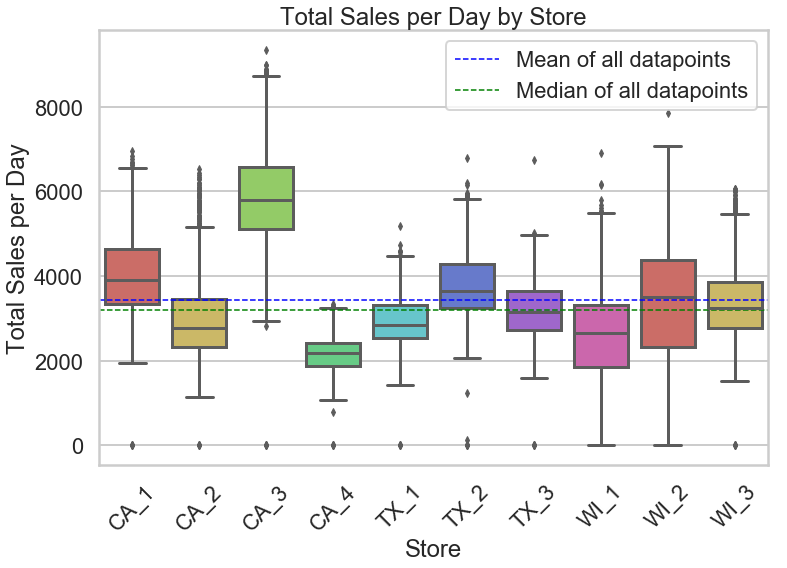

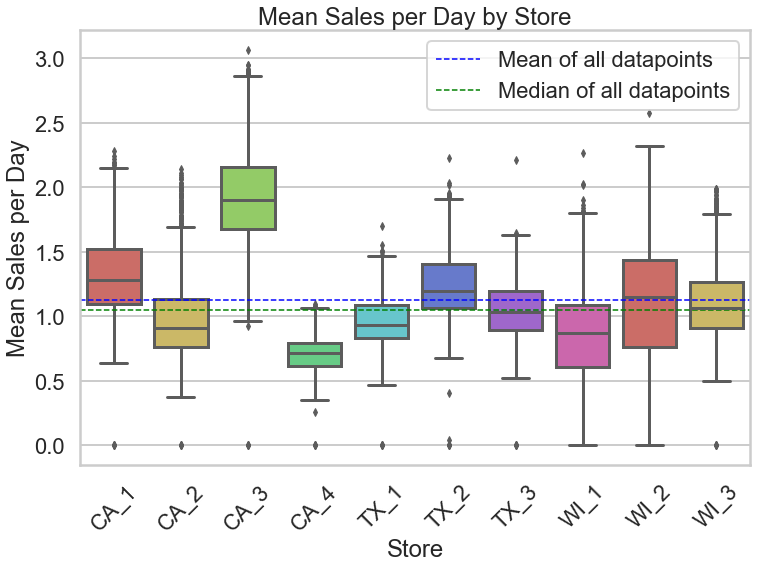

In [32]:
store_totalSales = stv.groupby(['store_id']).sum().T.reset_index(drop = True)
store_meanSales = stv.groupby(['store_id']).mean().T.reset_index(drop = True)

disp_boxplot(data = store_totalSales, title = 'Total Sales per Day by Store',
             xlabel = 'Store', ylabel = 'Total Sales per Day')
disp_boxplot(data = store_meanSales, title = 'Mean Sales per Day by Store',
             xlabel = 'Store', ylabel = 'Mean Sales per Day')
# 第一个箱图中形成箱的点的经济意义是某家门店某一天的销售额，两条基线的经济意义是所有门店的平均（中位）日销售额的平均值（中位数）
# 第二个箱图中形成箱的点的经济意义是某家门店某一天里每个商品的平均销售额，两条基线的经济意义是所有门店中每个商品的平均（中位）日销售额的平均值（中位数）

门店CA_3的每日销售额最高，CA_2和CA_1与平均值和中位数接近，CA_4则远低于平均值和中位数。表明CA很高的销售额是由CA_3带来的。

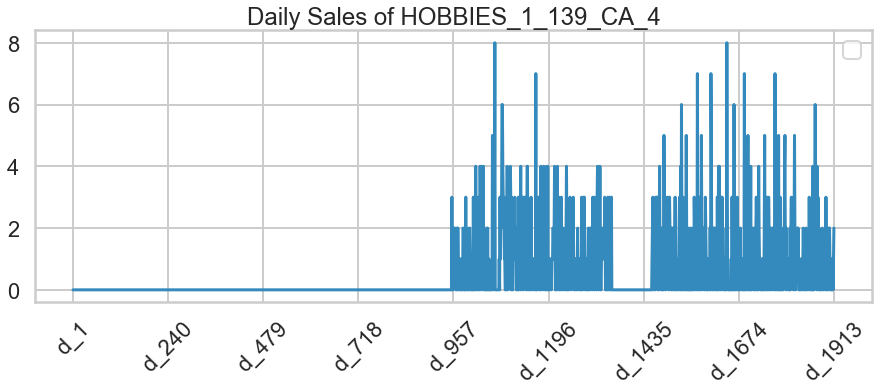

In [33]:
all_ids = list(stv['id']) # 所有商品的id
ids = [all_ids[x] for x in np.random.randint(0,len(all_ids), 1)] # 随机选取一个商品，查看其时间序列

title = 'Daily Sales of ' + ids[0][:-11] # 生成标题字符串
d_cols = [c for c in stv.columns if 'd_' in c] # 所有含"d_"的列名
ax = stv[stv['id'] == ids[0]][d_cols].T \
.plot(figsize = (15, 5), title = title)
xticks = list(range(0, len(d_cols), int(len(d_cols)/8))) # 生成刻度编号。8表示间隔个数，可根据画布大小和时间序列长度自定义。
xlabels = [d_cols[x] for x in xticks] # 生成对应的day_id
ax.set_xticks(xticks) # 自定义刻度
ax.set_xticklabels(xlabels, rotation=45) # 为每个刻度添加标签
plt.legend('') # 不显示图例
plt.show()

时间序列有零需求的时间段。

我们有一个日历数据，上面有日期的附加信息。日历数据可以与每日数据合并。从中发现每周和每年的趋势。

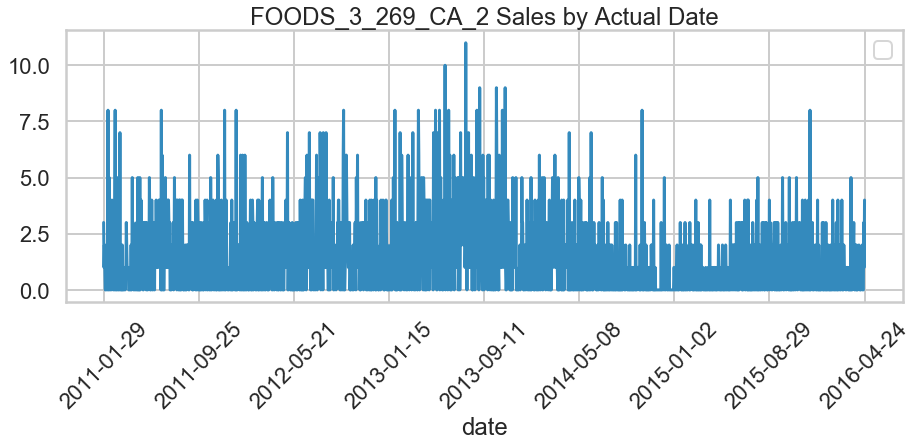

In [34]:
all_ids = list(stv['id'])
id_row = np.random.randint(0, len(all_ids), 1)
ids = [all_ids[x] for x in id_row]

example = stv[stv['id'] == ids[0]][d_cols].T # 提取某个商品的历史销售数据，转换成列显示
example = example.rename(columns = {id_row[0]:ids[0][:-11]}) # 修改列名为该商品的id
example = example.reset_index().rename(columns = {'index':'d'}) # 重置索引，生成'd'列，以便之后与cal合并
example = example.merge(cal, how = 'left') # 合并，获取日期数据
example = example.set_index('date') # 将日期数据设置成索引
title = ids[0][:-11] + ' Sales by Actual Date'
ax = example[ids[0][:-11]] \
.plot(title = title, figsize = (15, 5)) # 选取sales列，画图
xticks = list(range(0, len(example), int(len(example)/8)))
xticklabels = [example.index[r] for r in xticks] # 从索引中选取刻度标签
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation = 45)
plt.legend('')
plt.show()

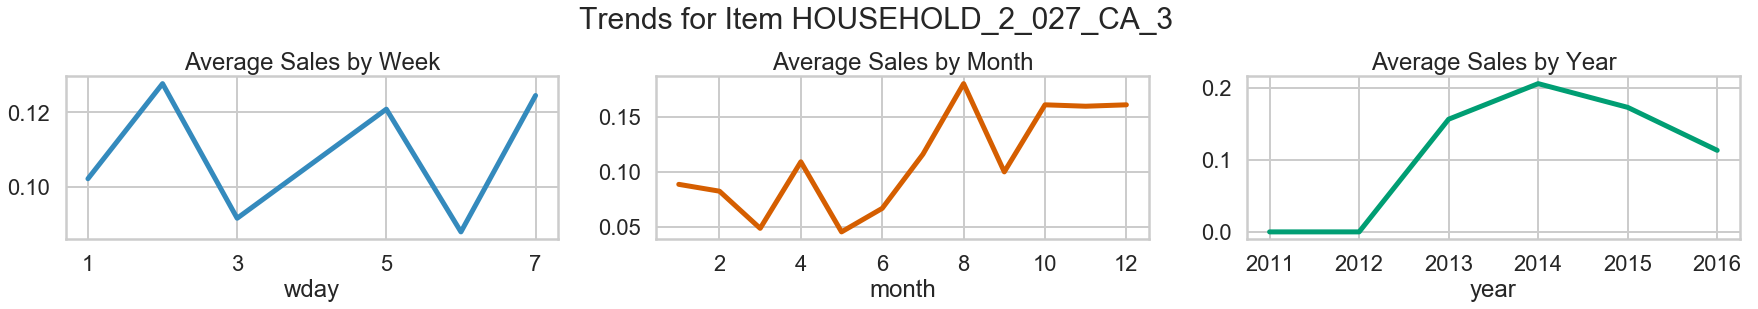

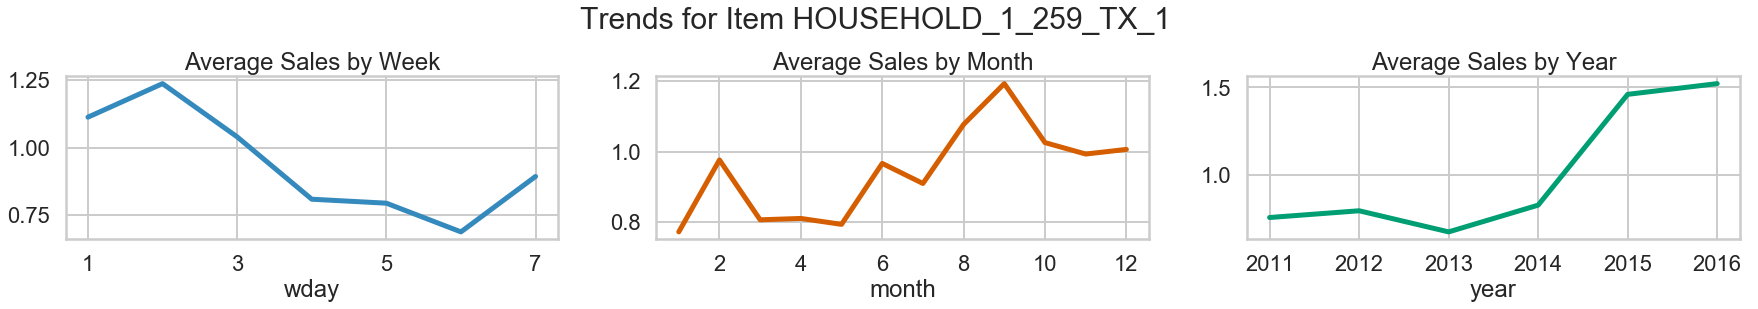

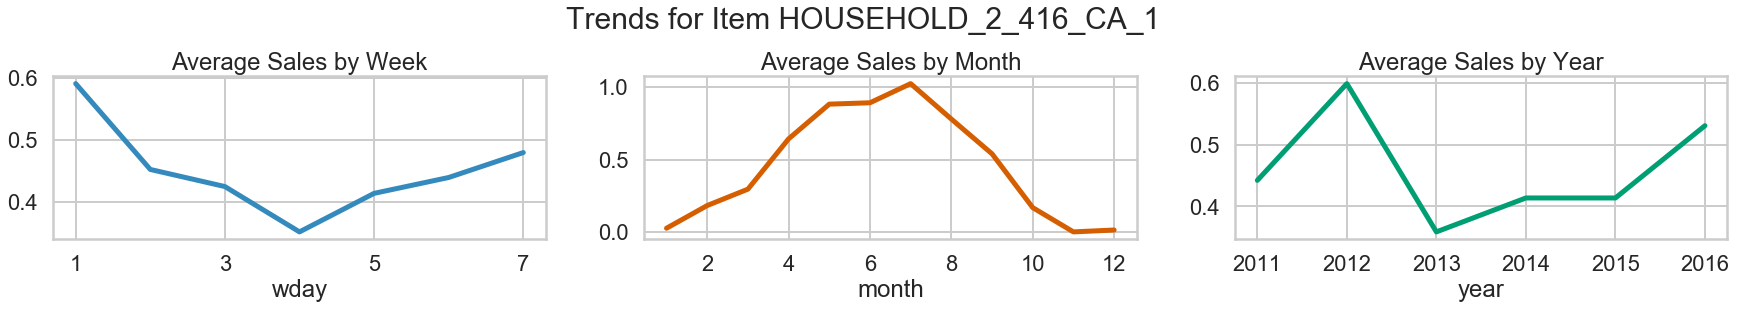

In [35]:
id_rows = np.random.randint(0, len(all_ids), 3)
ids = [all_ids[r] for r in id_rows]
examples = stv.iloc[id_rows][d_cols].T
for i in range(len(ids)):
    examples = examples.rename(columns = {id_rows[i]:ids[i]})
examples = examples.reset_index().rename(columns = {'index':'d'})
examples = examples.merge(cal, how = 'left')

for i in range(len(ids)):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10*len(ids), 3))
    examples[['wday',ids[i]]].groupby('wday').mean()[ids[i]].plot(ax = ax1, kind = 'line', linewidth = 5,
                                                                  title = 'Average Sales by Week', color = color_pal[0])
    ax1.set_xticks(list(range(1, 8, 2)))
    examples[['month',ids[i]]].groupby('month').mean()[ids[i]].plot(ax = ax2, kind = 'line', linewidth = 5,
                                                                    title = 'Average Sales by Month', color = color_pal[4])
    ax2.set_xticks(list(range(2, 13, 2)))
    examples[['year',ids[i]]].groupby('year').mean()[ids[i]].plot(ax = ax3, kind = 'line', linewidth = 5,
                                                                  title = 'Average Sales by Year', color = color_pal[7])
    fig.suptitle('Trends for Item %s' % ids[i][:-11], size = 30, y = 1.2) # 为每行设置子标题，字体大小为20，上下间距为原来的1.1倍
    plt.show()

weekday的1表示星期六。可以看出一般周末买东西的人比较多。

In [36]:
# unit_width调整每张图的长度，level的选项有'Category','Department','State','Store'
def salesTrends_plot(sales, unit_width, level):
    stores = sales.columns
    sales = sales.reset_index().rename(columns = {'index':'d'})
    sales_cal = sales.merge(cal, how = 'left')

    for i in range(len(stores)):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (unit_width*len(stores), 3))
        sales_cal[['wday', stores[i]]].groupby(['wday']).mean().plot(ax = ax1, kind = 'line', linewidth = 5,
                                                                     color = color_pal[0], title = 'Average Sales of Week')
        ax1.legend('')
        sales_cal[['month', stores[i]]].groupby(['month']).mean().plot(ax = ax2, kind = 'line', linewidth = 5,
                                                                       color = color_pal[4], title = 'Average Sales of Month')
        ax2.legend('')
        sales_cal[['year', stores[i]]].groupby(['year']).mean().plot(ax = ax3, kind = 'line', linewidth = 5,
                                                                     color = color_pal[7], title = 'Average Sales of Year')
        ax3.legend('')
        fig.suptitle('Trends for %s %s' % (level, stores[i]), size = 30, y = 1.2)
        plt.show()

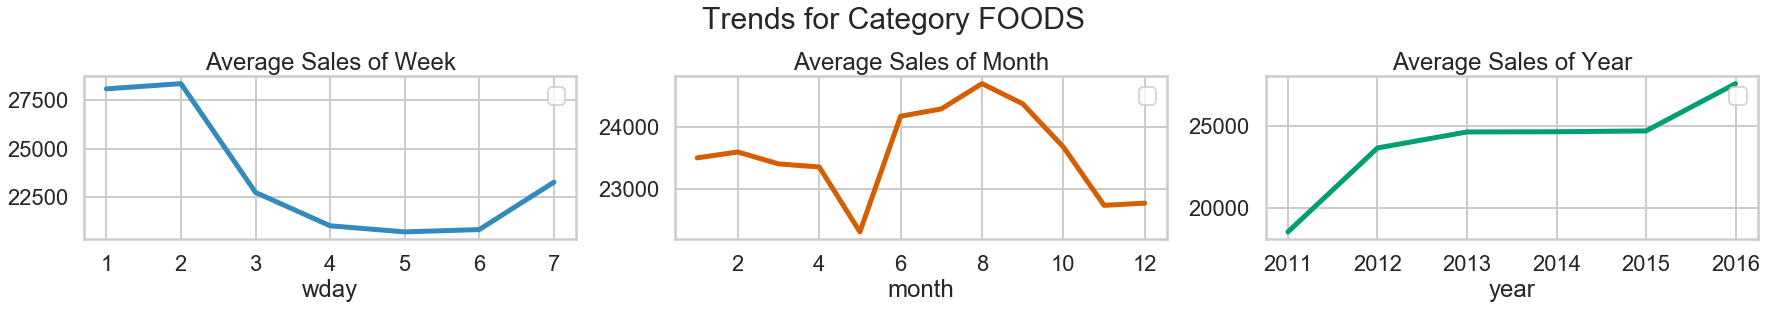

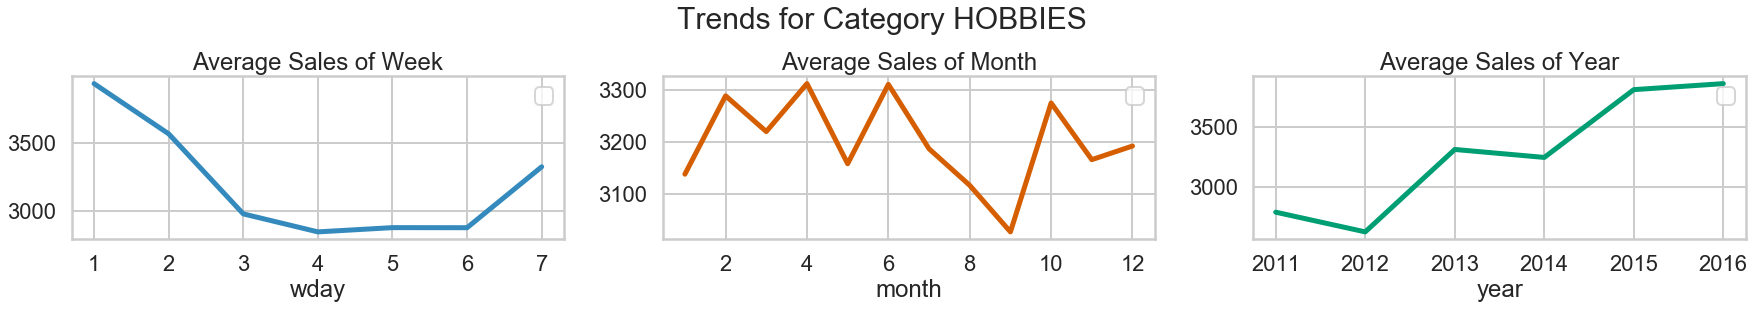

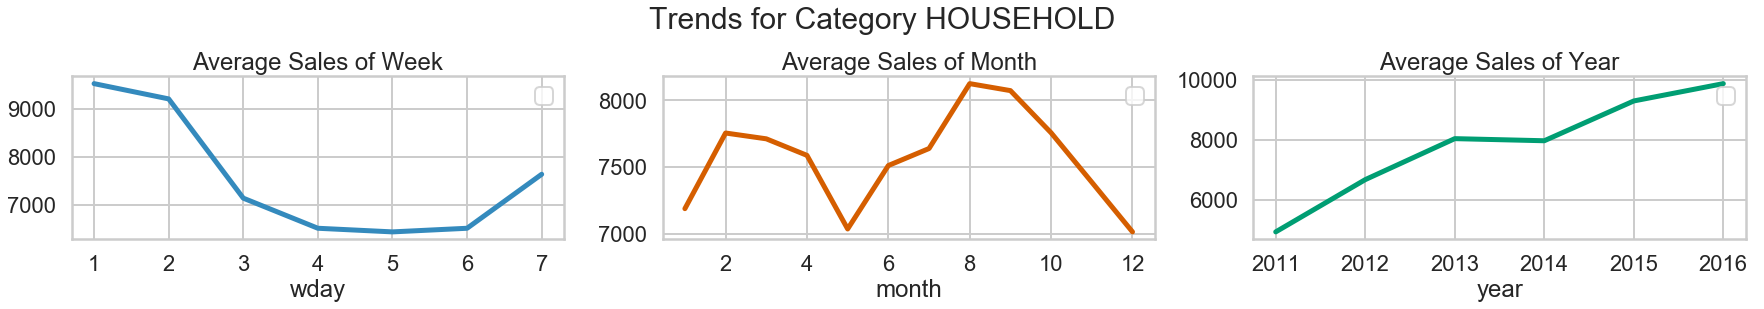

In [37]:
cat_sales = stv.groupby(['cat_id']).sum().T
salesTrends_plot(cat_sales, 10, 'Category')

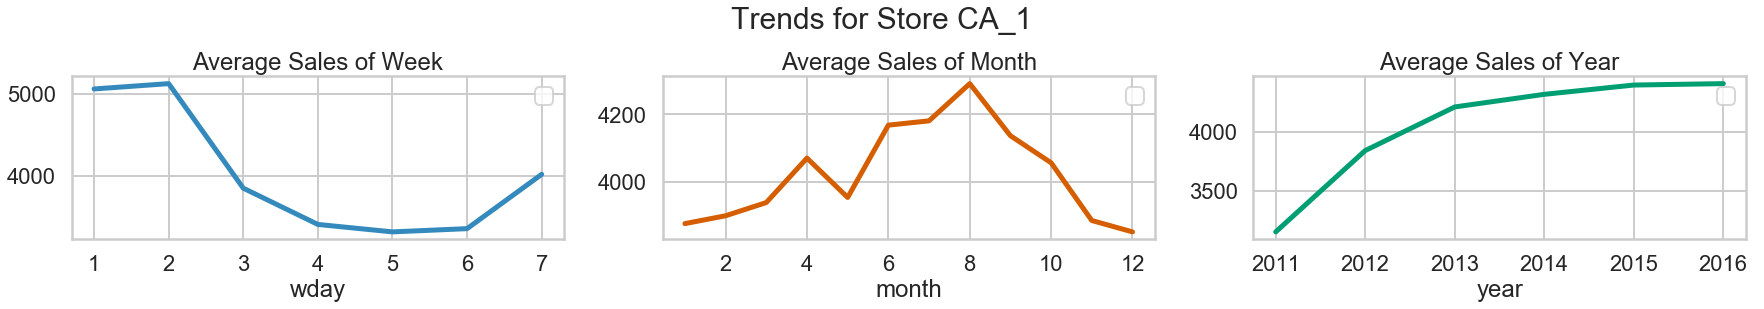

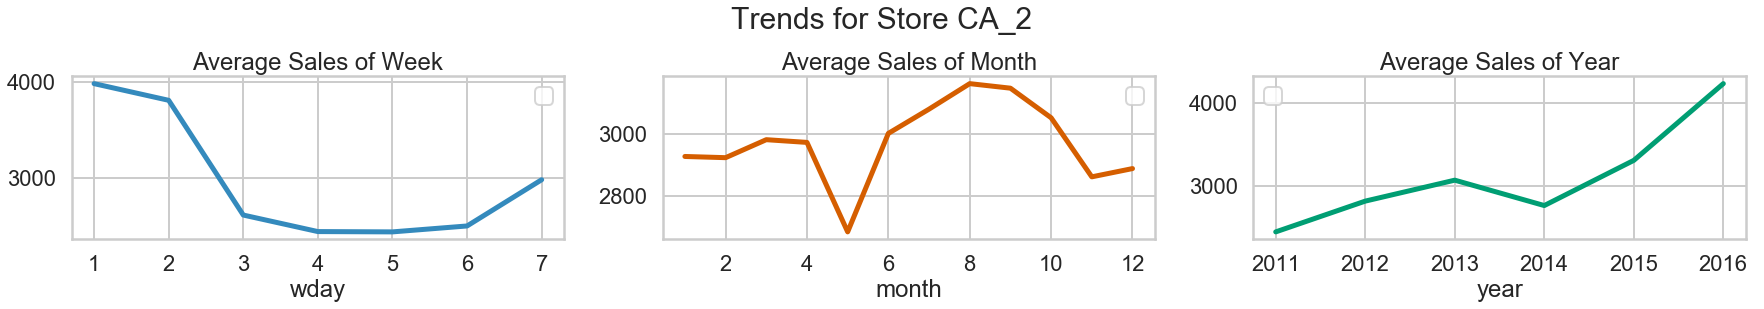

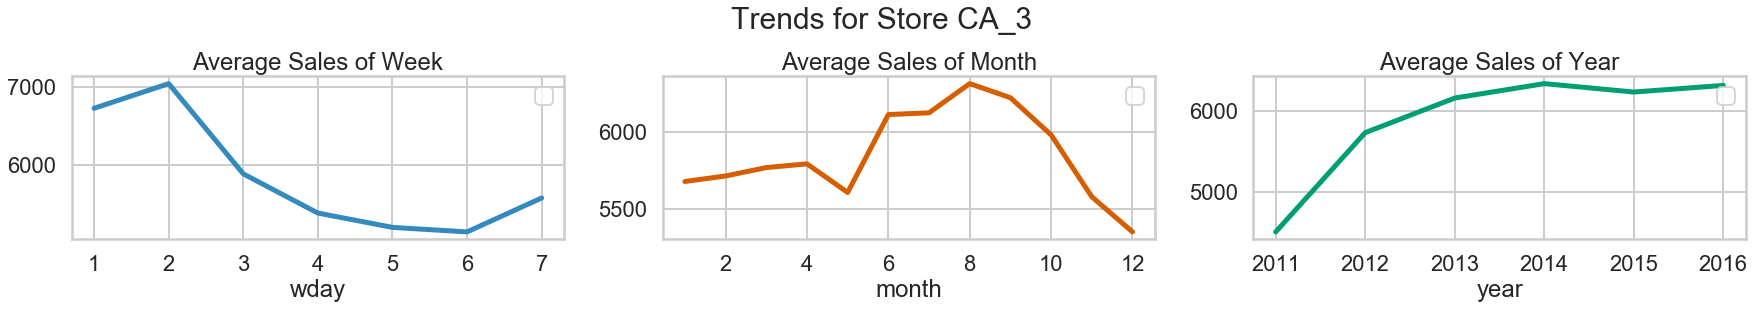

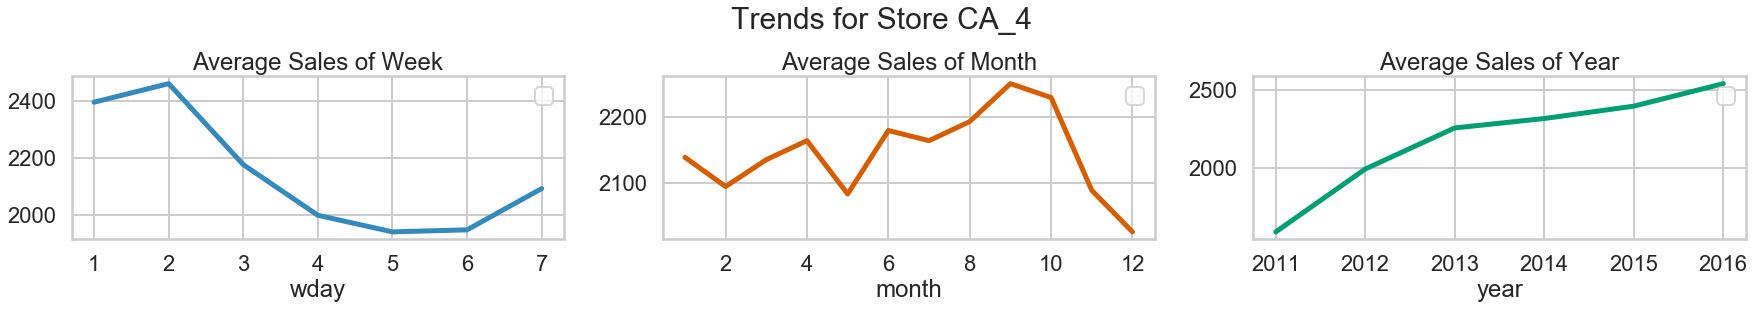

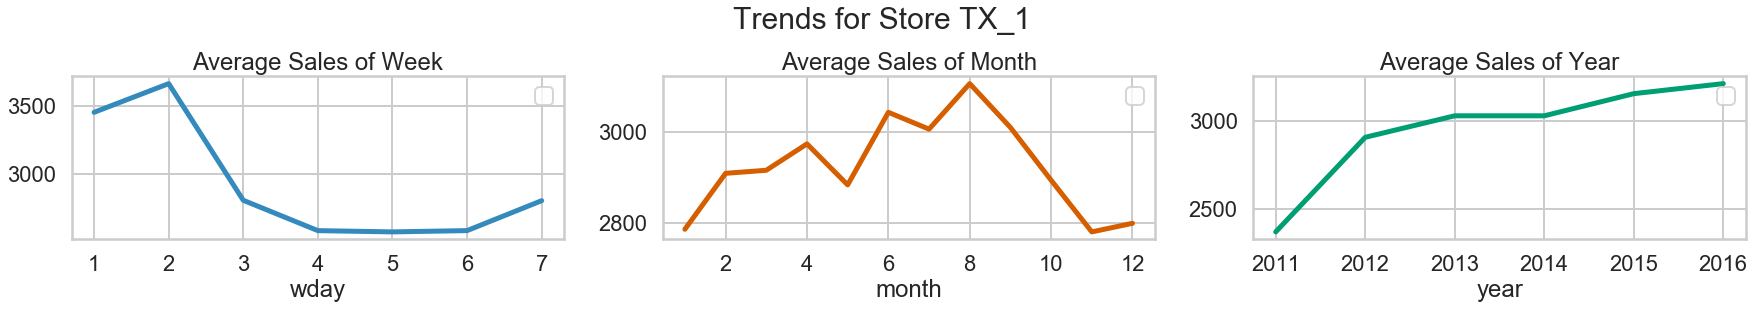

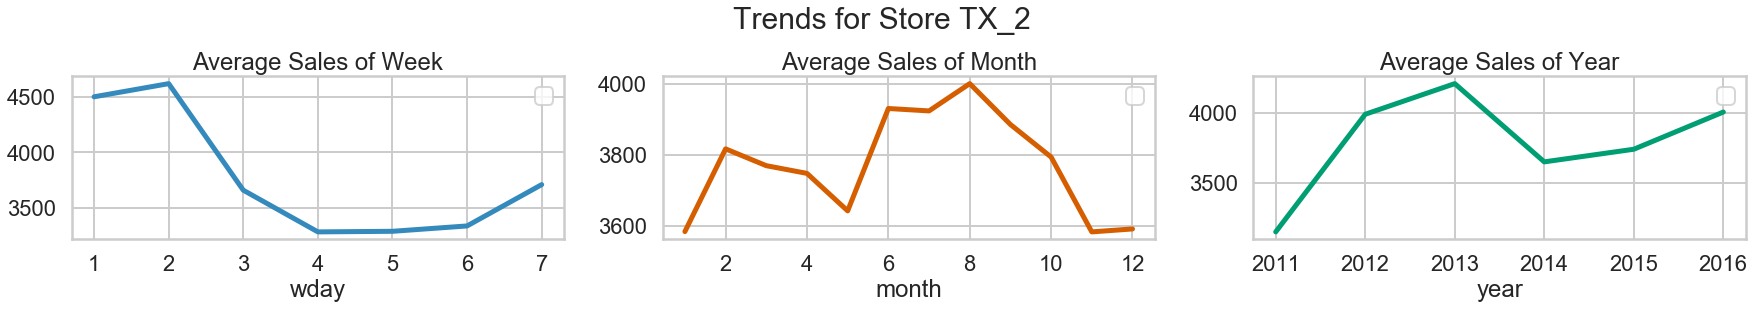

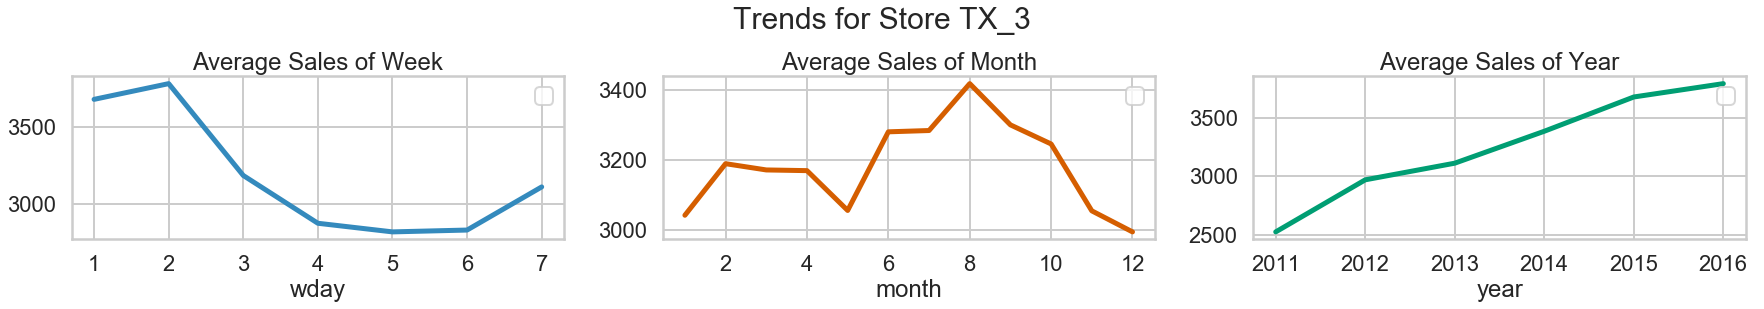

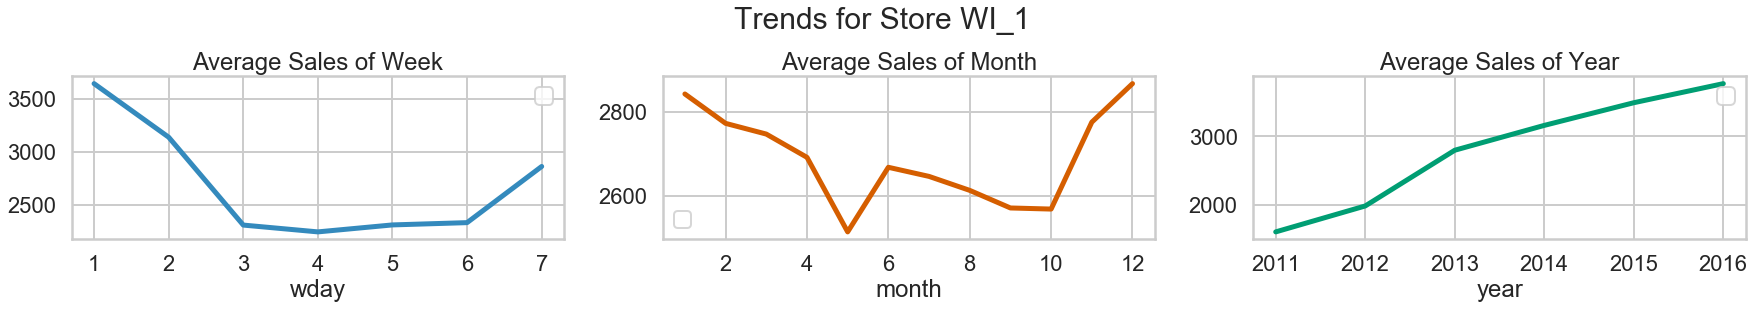

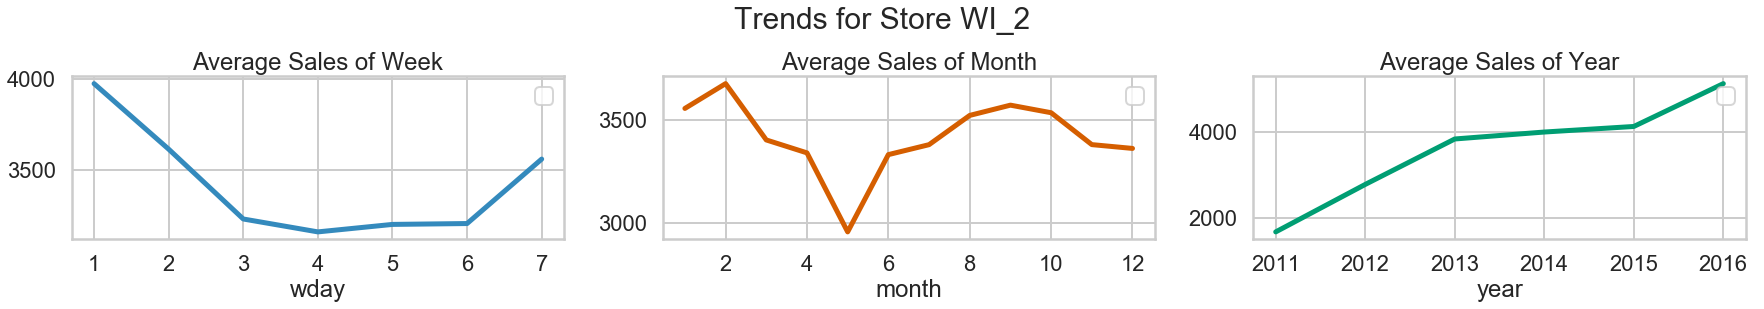

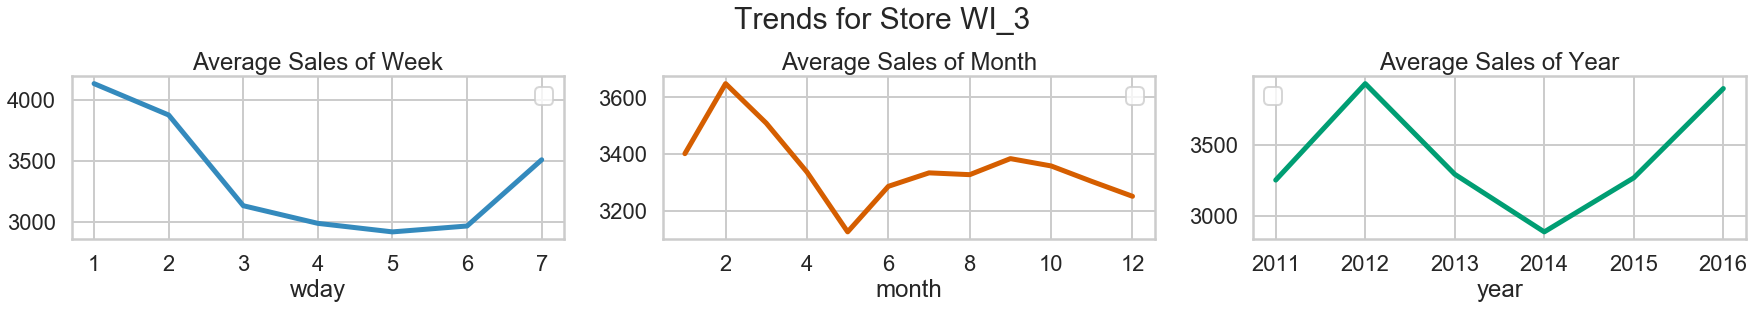

In [38]:
store_sales = stv.groupby(['store_id']).sum().T
salesTrends_plot(store_sales, 3, 'Store')

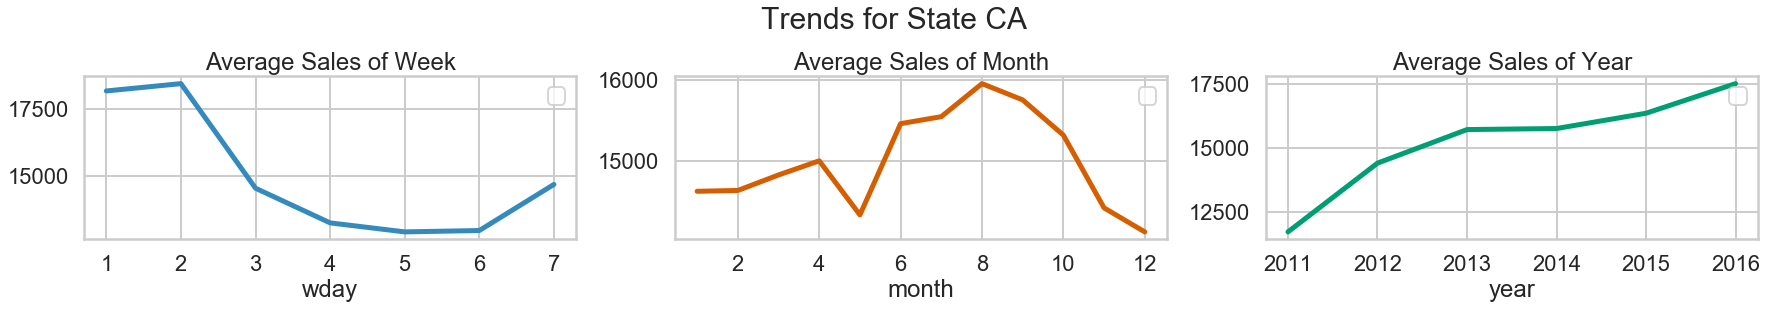

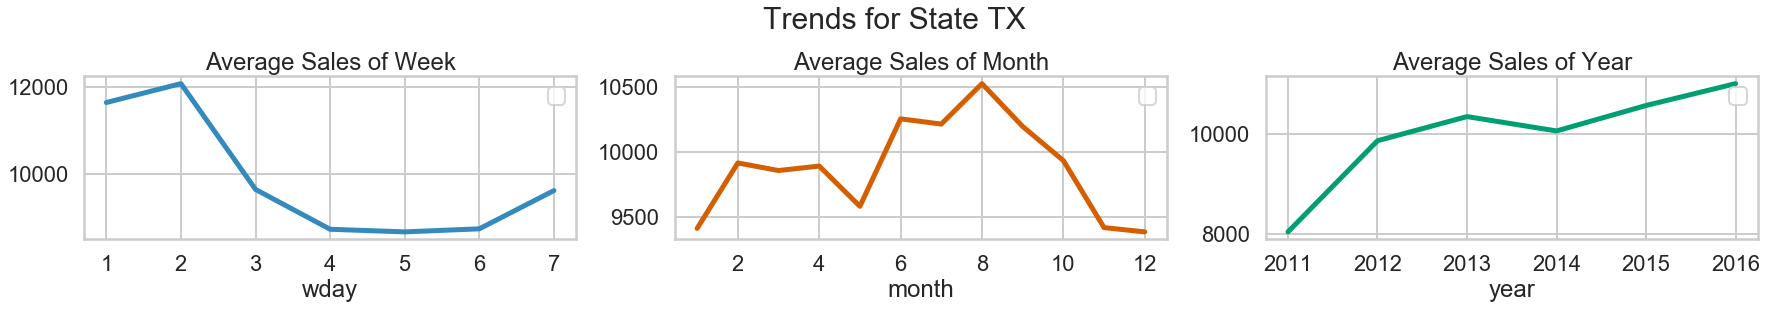

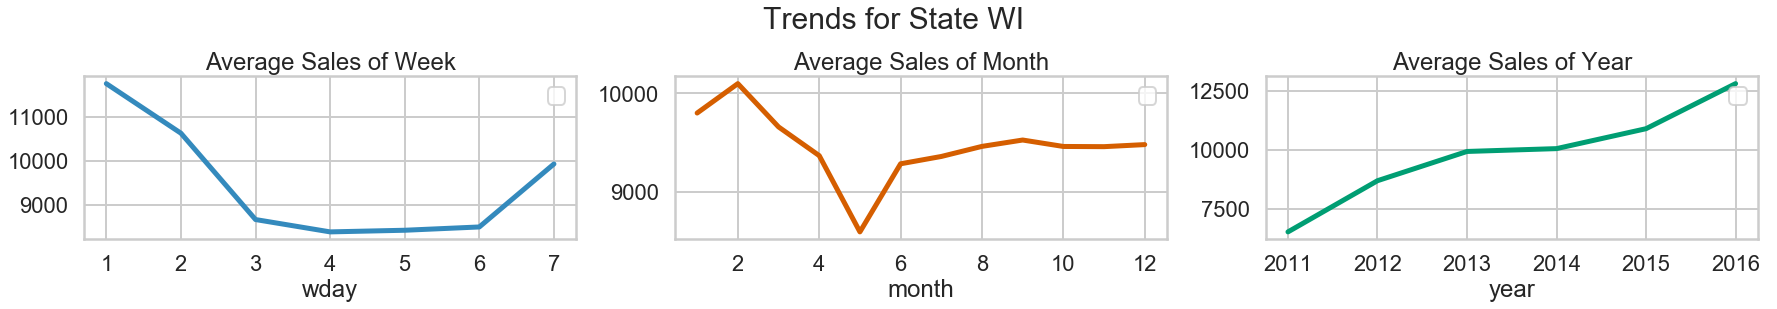

In [39]:
state_sales = stv.groupby(['state_id']).sum().T
salesTrends_plot(state_sales, 10, 'State')

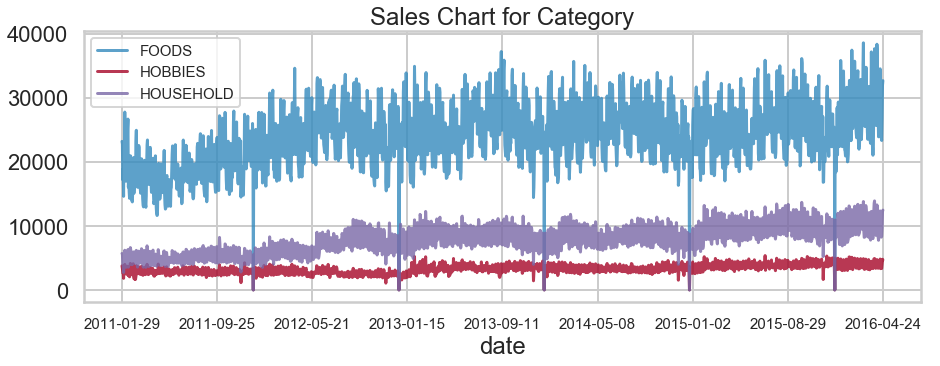

In [42]:
sales_chart = stv.groupby('cat_id').sum().T \
.merge(cal[['d', 'date']].set_index('d'), left_index = True, right_index = True) \
.set_index('date')
ax = sales_chart.plot(figsize = (15, 5), alpha = 0.8, title = 'Sales Chart for Category')
# alpha=0.8表示设置透明度为原色的80%
# left_index一般和right_index同时使用，用于合并索引相同的表
xticks = list(range(0, len(sales_chart), int(len(sales_chart)/8)))
xticklabels = [sales_chart.index[r] for r in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, size = 15)
plt.legend(prop = {'size':15}) # 修改图例字体大小
plt.show()

FOODS的峰值特征与其他两个类有明显不同。

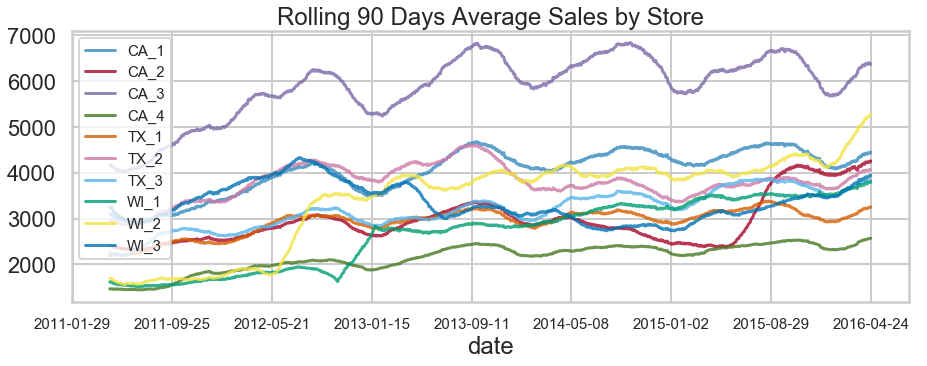

In [41]:
# 90天滚动聚合趋势图
rolling_sales = stv.groupby(['store_id']).sum().T \
.rolling(90).mean() \
.merge(cal[['d', 'date']].set_index('d'), left_index = True, right_index = True) \
.set_index('date')
ax = rolling_sales.plot(figsize = (15, 5), title = 'Rolling 90 Days Average Sales by Store', alpha = 0.8)
xticks = list(range(0, len(rolling_sales), int(len(rolling_sales)/8)))
xticklabels = [rolling_sales.index[r] for r in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, size = 15)
plt.legend(prop = {'size':15})
plt.show()

1.有些商店的走势非常平稳，比如CA_3。

2.CA_2在2015年的销售额有大幅提升。

In [62]:
from matplotlib.patches import Polygon
from datetime import datetime
from dateutil.relativedelta import relativedelta

def calmap(ax, year, data):
    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders
    xticks, labels = [], []
    start = datetime(year,1,1).weekday()
    for month in range(1,13):
        first = datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]
        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",
                       linewidth=1, zorder=20, clip_on=False)
        ax.add_artist(poly)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(0.5 + np.arange(7))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    ax.set_title("{}".format(year), weight="semibold")
    
    # Clearing first and last day from the data
    valid = datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    # Showing data
    ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=-1, vmax=1,
              cmap="RdYlBu_r", origin="lower", alpha=.75)

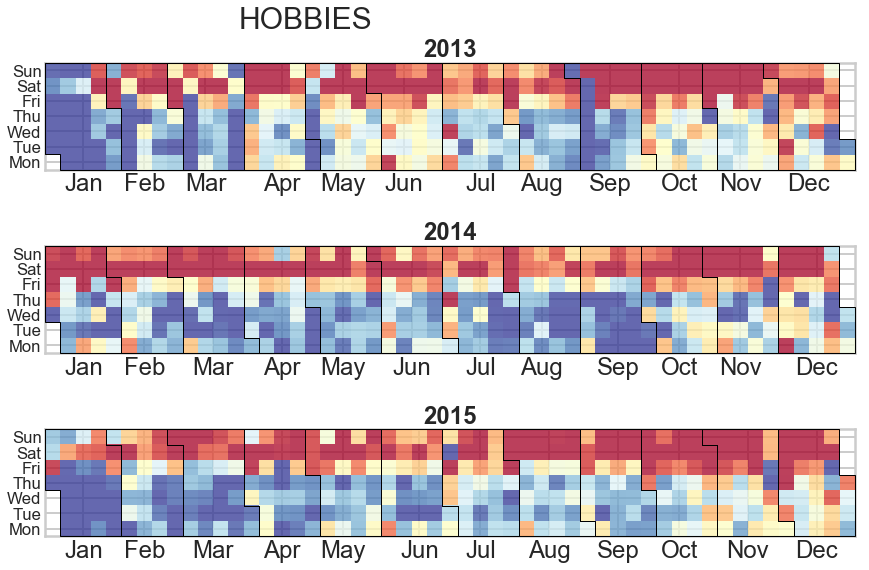

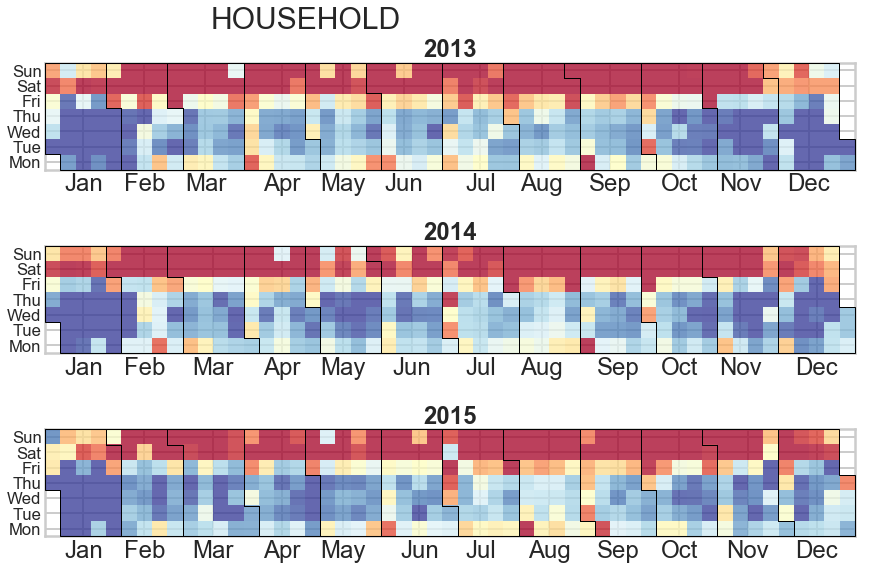

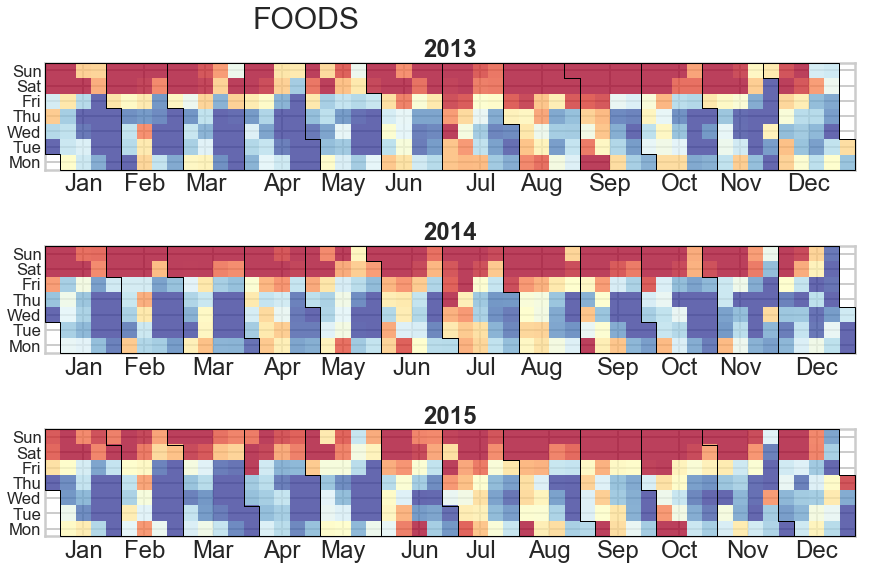

In [68]:
from sklearn.preprocessing import StandardScaler
sscale = StandardScaler()
sales_chart.index = pd.to_datetime(sales_chart.index)
for i in stv['cat_id'].unique():
    fig, axes = plt.subplots(3, 1, figsize=(20, 8))
    items_col = [c for c in sales_chart.columns if i in c]
    sales2013 = sales_chart.loc[sales_chart.index.isin(pd.date_range('31-Dec-2012',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2013.values.reshape(-1, 1)))
    calmap(axes[0], 2013, vals.reshape(53,7).T)
    sales2014 = sales_chart.loc[sales_chart.index.isin(pd.date_range('30-Dec-2013',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2014.values.reshape(-1, 1)))
    calmap(axes[1], 2014, vals.reshape(53,7).T)
    sales2015 = sales_chart.loc[sales_chart.index.isin(pd.date_range('29-Dec-2014',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2015.values.reshape(-1, 1)))
    calmap(axes[2], 2015, vals.reshape(53,7).T)
    plt.suptitle(i, fontsize=30, x=0.4, y=1.01)
    plt.tight_layout()
    plt.show()

随着时间的推移，食品的购买量往往会减少。

这可能是因为人们在月初领了工资？

一月份和假期结束后，家庭用品和爱好用品的销量要少得多。

无论商品类别如何，周末都是更受欢迎的购物日。

In [71]:
sellp.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


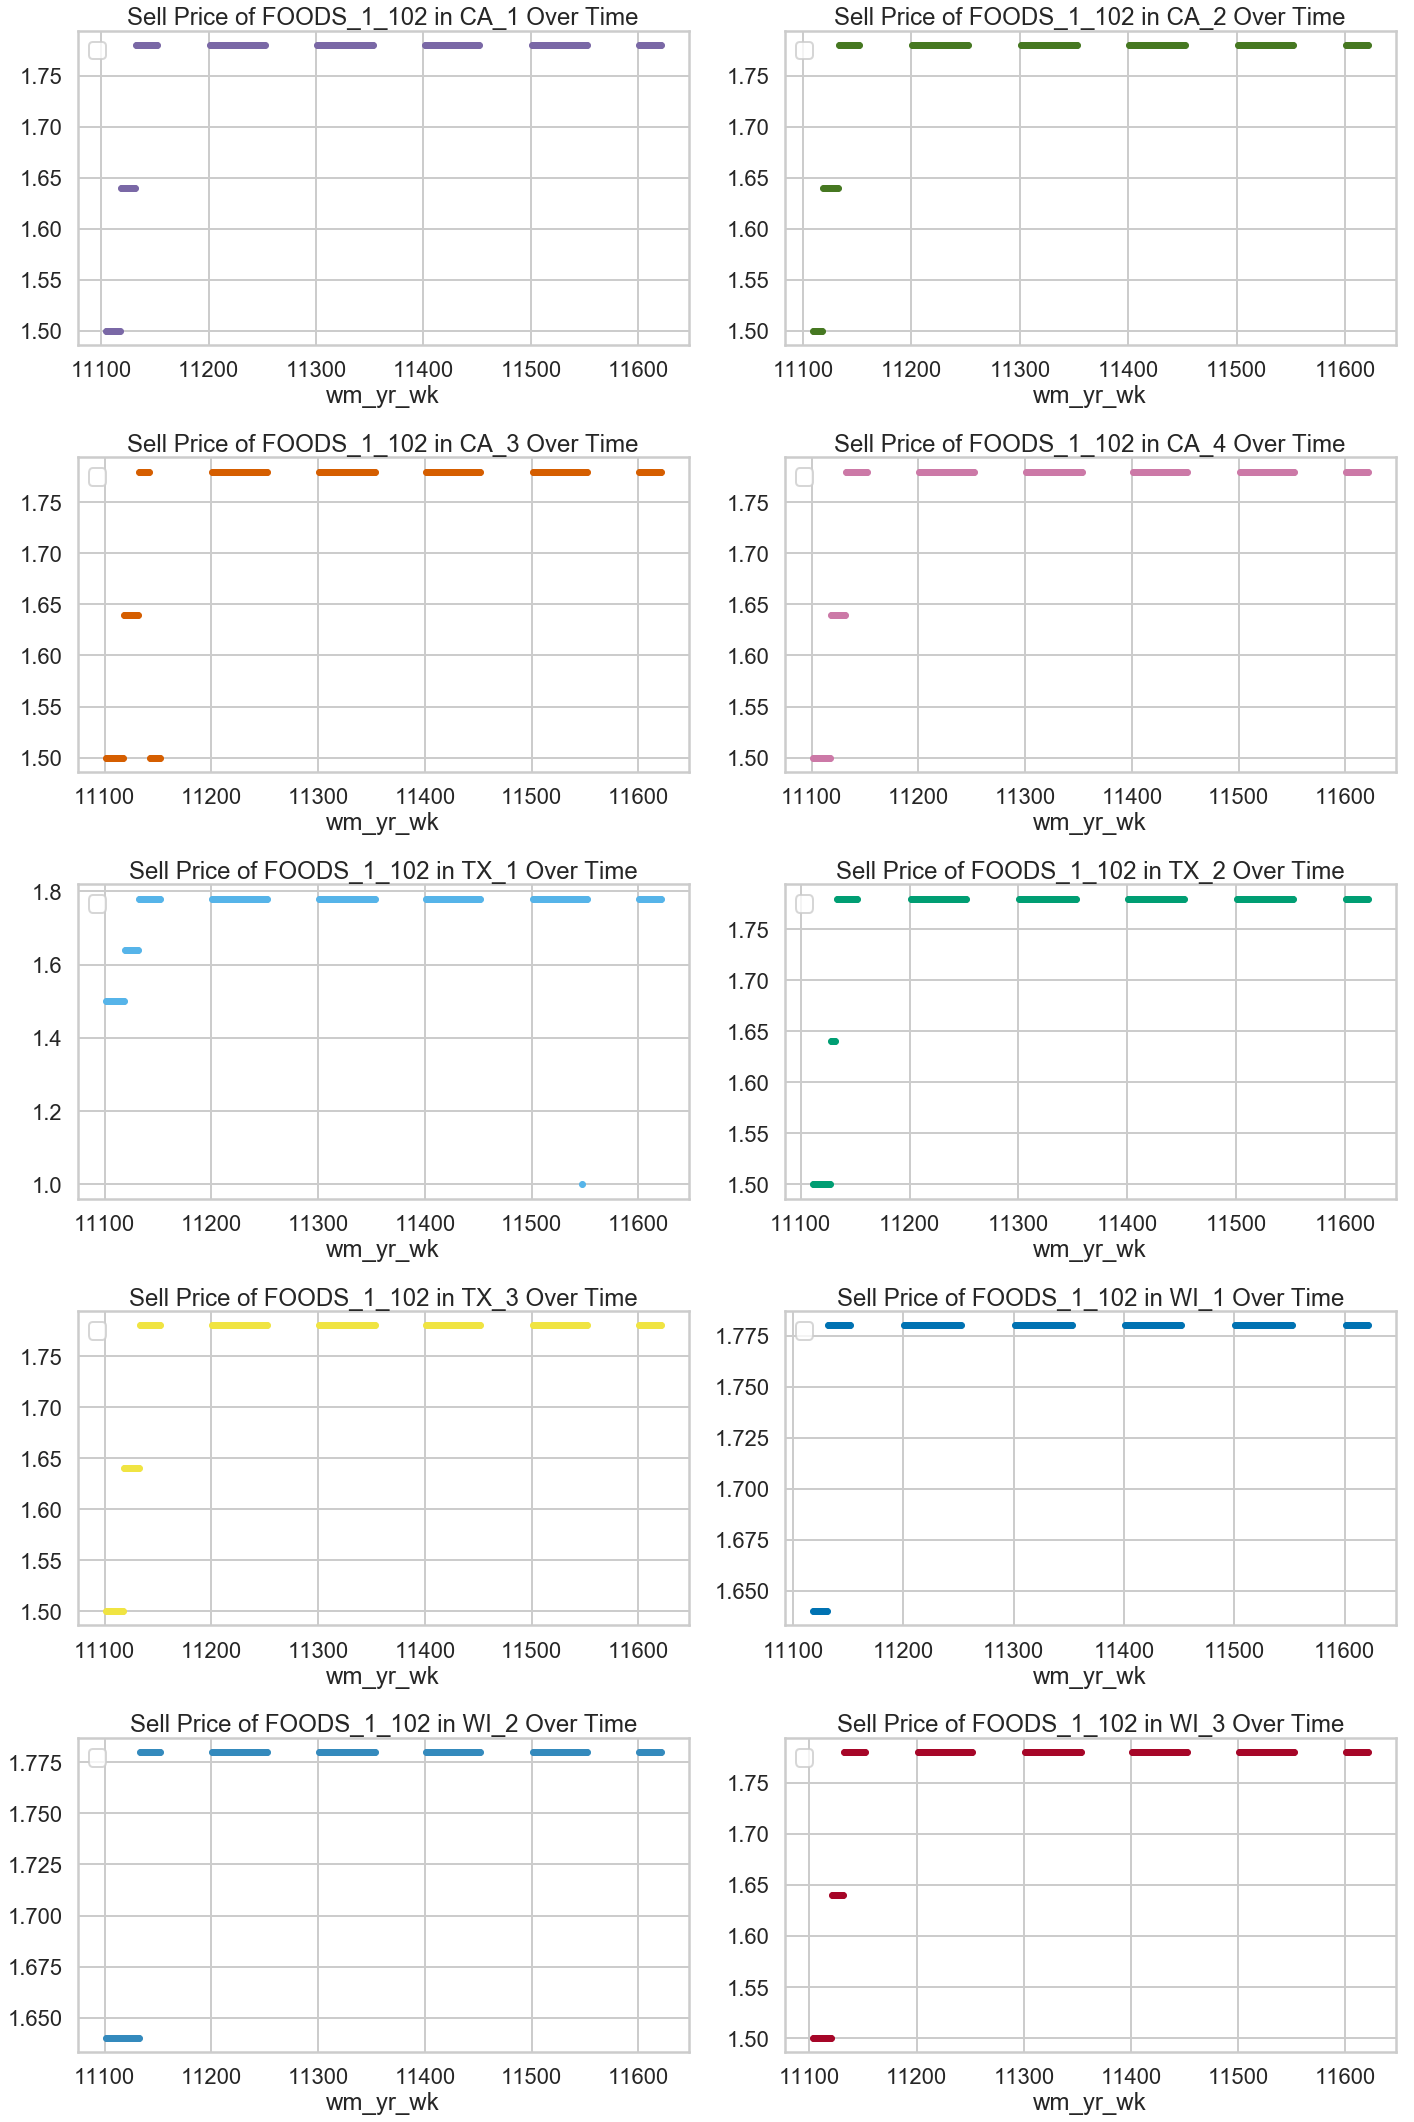

In [121]:
fig, axes = plt.subplots(5, 2, figsize = (20, 30))
axes = axes.flatten() # 将axes展开成一维数组
items = sellp['item_id'].unique()
rand_item = items[np.random.randint(0, len(items))] # 随机选取一件商品
i = 0
for store, price in sellp[sellp['item_id'] == rand_item].groupby('store_id'):
    ax = price.plot(x = 'wm_yr_wk', y = 'sell_price', style = '.', color = next(color_cycle),
                    ax = axes[i], title = 'Sell Price of %s in %s Over Time' % (rand_item, store))
    ax.legend('')
    i += 1
plt.tight_layout()
plt.show()

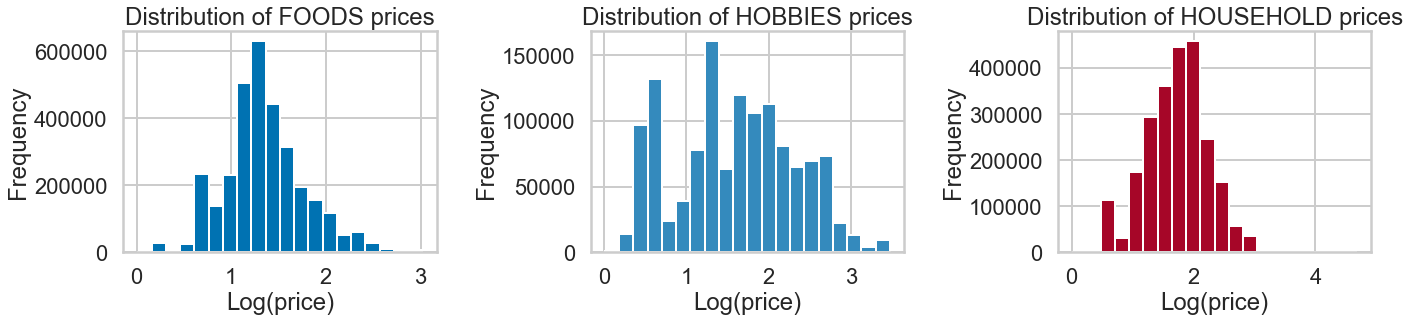

In [120]:
sellp['Category'] = sellp['item_id'].str.split('_', expand=True)[0]
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
i = 0
for cat, price in sellp.groupby('Category'):
    ax = price['sell_price'].apply(np.log1p).plot(kind='hist', bins=20, color=next(color_cycle),
                                                  ax=axes[i], title='Distribution of %s prices' % cat)
    ax.set_xlabel('Log(price)')
    i += 1
plt.tight_layout()
plt.show()